In [1]:
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Define Helper Functions

In [2]:
def preprocess_image(image_path, target_size=(400, 400)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return vgg19.preprocess_input(img)

def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image_array):
    image = deprocess_image(image_array[0])
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Load Images and Prepare Data

In [3]:
content_image_path = "original.png"  # Replace with the path to your content image
style_image_path = "style_image.png"      # Replace with the path to your style image

content_image = preprocess_image(content_image_path)
style_image = preprocess_image(style_image_path)

# Load Pre-trained VGG19 and Define Feature Layers

In [4]:
def get_model():
    vgg = vgg19.VGG19(weights='imagenet', include_top=False)
    content_layer = 'block5_conv2'  # Content layer
    style_layers = [
        'block1_conv1',
        'block2_conv1',
        'block3_conv1',
        'block4_conv1',
        'block5_conv1',
    ]
    output_layers = [vgg.get_layer(name).output for name in ([content_layer] + style_layers)]
    return Model(inputs=vgg.input, outputs=output_layers), content_layer, style_layers

model, content_layer, style_layers = get_model()
model.trainable = False

80134624/80134624 [==============================] - 5s 0us/step


# Define Loss Functions

In [5]:
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

# Compute Combined Loss

In [6]:
def compute_loss(model, loss_weights, init_image, content_features, style_features):
    input_tensor = tf.concat([init_image, content_image, style_image], axis=0)
    features = model(input_tensor)
    
    content_output = features[0]
    style_outputs = features[1:]
    
    content_weight, style_weight = loss_weights
    
    content_loss_val = content_loss(content_output, content_features)
    style_loss_val = 0
    for style_feature, target_gram in zip(style_outputs, style_features):
        style_loss_val += style_loss(style_feature, target_gram)
    style_loss_val /= len(style_layers)
    
    total_loss = content_weight * content_loss_val + style_weight * style_loss_val
    return total_loss

# Style Transfer Optimization

In [7]:
@tf.function
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        loss = compute_loss(**cfg)
    return tape.gradient(loss, cfg['init_image']), loss

# Set weights for content and style
style_weight = 1e-4
content_weight = 1e3
loss_weights = (content_weight, style_weight)

# Get feature representations for content and style
content_features = model(content_image)[0]
style_features = [gram_matrix(feature) for feature in model(style_image)[1:]]
init_image = tf.Variable(content_image, dtype=tf.float32)

# Optimization setup
optimizer = tf.optimizers.Adam(learning_rate=5.0)
epochs = 1000
steps_per_epoch = 100
cfg = {
    'model': model,
    'loss_weights': loss_weights,
    'init_image': init_image,
    'content_features': content_features,
    'style_features': style_features,
}

# Run Style Transfer

Epoch 0, Loss: 3911152.0


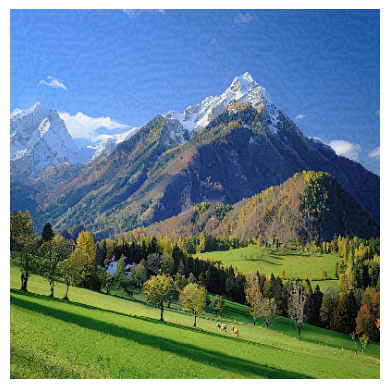

KeyboardInterrupt: 

In [8]:
for i in range(epochs):
    grads, loss = compute_grads(cfg)
    optimizer.apply_gradients([(grads, init_image)])
    if i % 100 == 0:
        print(f"Epoch {i}, Loss: {loss.numpy()}")
        display_image(init_image.numpy())